# Sentiment Analysis of Nausicaa

In [ ]:
# Imports
from textblob import TextBlob
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import re
import json
from scipy.ndimage import gaussian_filter1d

## Cleaning the Script and Extracting Character Lines

In [61]:
script_dict = {
    "NAUSICAA": [],
    "JHIL": [],
    "MITO": [],
    "YUPA": [],
    "GRNDMOTHR": [],
    "ASBEL": [],
    "KUSHANA": [],
    "KUROTOWA": [],
    "GOLL": [],
    "UNCLE": [],
    "OTHER": [],
}

other_characters = [
    "OLD UNCLE",
    "CHILD",
    "VILLAGER",
    "TOETO",
    "OLD WOMAN",
    "VOICE",
    "RASTEL",
    "MAN",
    "BOY",
    "GIRL",
    "WOMAN",
    "SOLDIER",
    "GAURD",
    "RADIO",
    "PILOT",
    "LEADER",
]


def parse_script(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()

    current_character = None
    dialogue_index = 0

    for line in lines:
        line = line.strip()

        if not line:
            continue

        found = False

        for name in script_dict.keys():
            if line.startswith(name):
                current_character = name
                script_dict[current_character].append(f"<{dialogue_index}> {line}")
                dialogue_index += 1
                found = True
                break

        if not found:
            for name in other_characters:
                if line.startswith(name):
                    current_character = "OTHER"
                    script_dict["OTHER"].append(f"<{dialogue_index}> {line}")
                    dialogue_index += 1
                    found = True
                    break

        if not found and current_character:
            script_dict[current_character][-1] += f" {line}"


parse_script("Scripts/NausicaaNOMETA.txt")

for name, lines in script_dict.items():
    print(f"{name}: {len(lines)} lines")


def print_script_dict(script_dict):
    for name, lines in script_dict.items():
        print(f"{name}:")
        for line in lines:
            print(f"  {line}")
        print()


# print_script_dict(script_dict)

NAUSICAA: 180 lines
JHIL: 7 lines
MITO: 70 lines
YUPA: 57 lines
GRNDMOTHR: 23 lines
ASBEL: 40 lines
KUSHANA: 43 lines
KUROTOWA: 47 lines
GOLL: 35 lines
UNCLE: 43 lines
OTHER: 140 lines


In [62]:

all_lines_ordered = []

for character, lines in script_dict.items():
    for entry in lines:
        match = re.match(r"<(\d+)>", entry)
        if match:
            idx = int(match.group(1))
            text = entry.split(">", 1)[1].strip()
            all_lines_ordered.append((idx, character, text))

all_lines_ordered.sort()
all_lines_array = [f" {line}" for idx, name, line in all_lines_ordered]

# print pretty with index
def print_pretty_script(script):
    for idx, line in enumerate(script):
        print(f"{idx}: {line}")

# print_pretty_script(all_lines_array)

## Complete Movie Sentiment Analysis

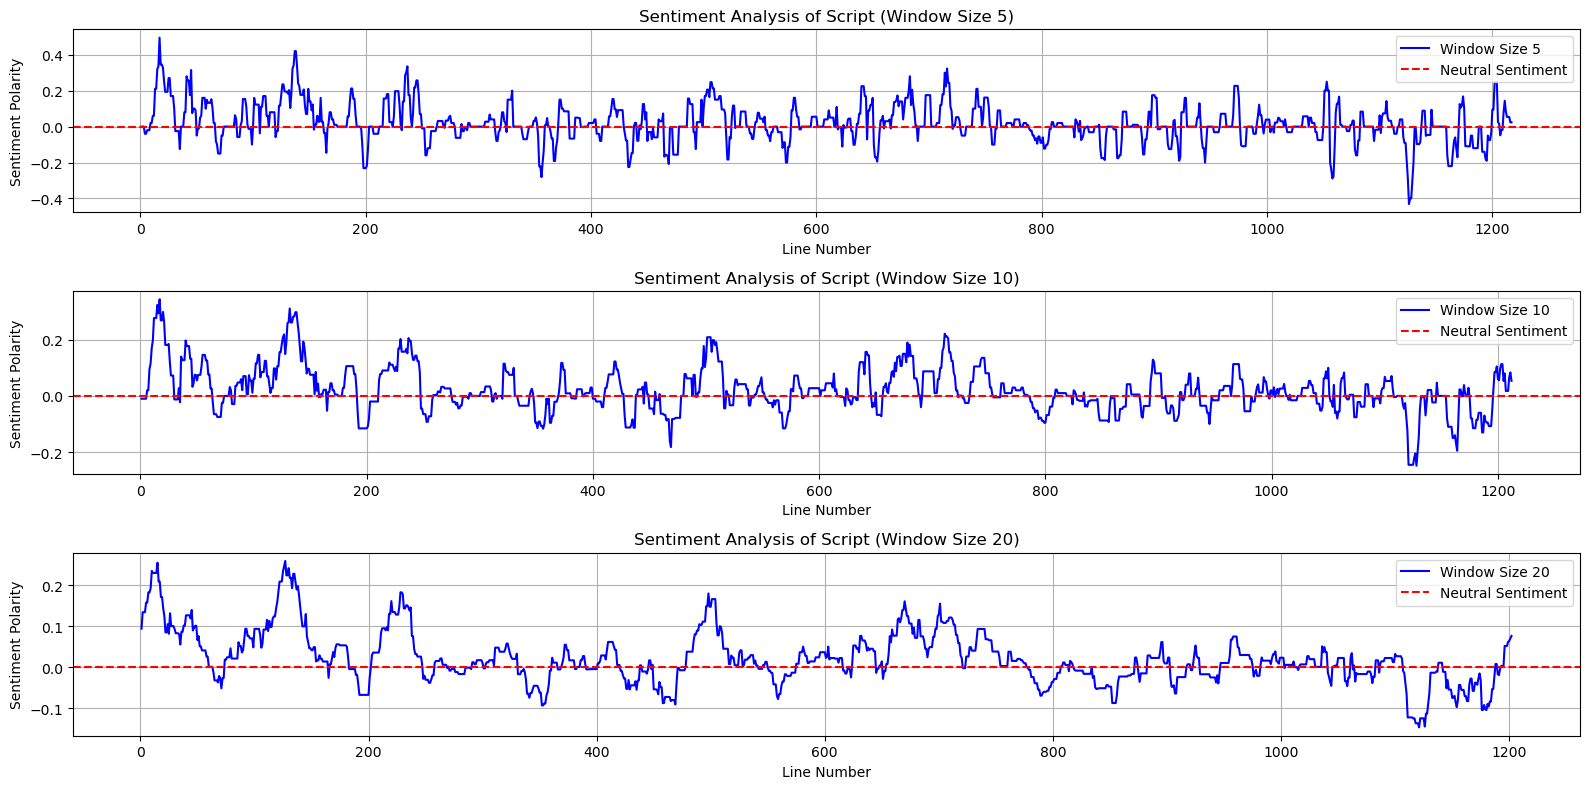

In [63]:
def analyze_sentiment(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = [line.strip() for line in file if line.strip()]  
    
    # Perform sentiment analysis
    sentiment_scores = [TextBlob(line).sentiment.polarity for line in lines]
    line_numbers = list(range(1, len(sentiment_scores) + 1))

    # Smooth the sentiment scores
    window_sizes = [5, 10, 20]
    smoothed_scores = {
        f"Window Size {w}": np.convolve(sentiment_scores, np.ones(w)/w, mode='valid')
        for w in window_sizes
    }

    plt.figure(figsize=(16, 8))
    
    for i, (label, scores) in enumerate(smoothed_scores.items(), start=1):
        plt.subplot(3, 1, i)
        smoothed_line_numbers = line_numbers[:len(scores)]
        plt.plot(smoothed_line_numbers, scores, label=label, color="blue", linestyle="-")
        plt.axhline(0, color="red", linestyle="--", label="Neutral Sentiment")
        plt.title(f"Sentiment Analysis of Script ({label})")
        plt.xlabel("Line Number")
        plt.ylabel("Sentiment Polarity")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

analyze_sentiment("Scripts/NausicaaNOMETA.txt")


## Select Character Sentiment Analysis

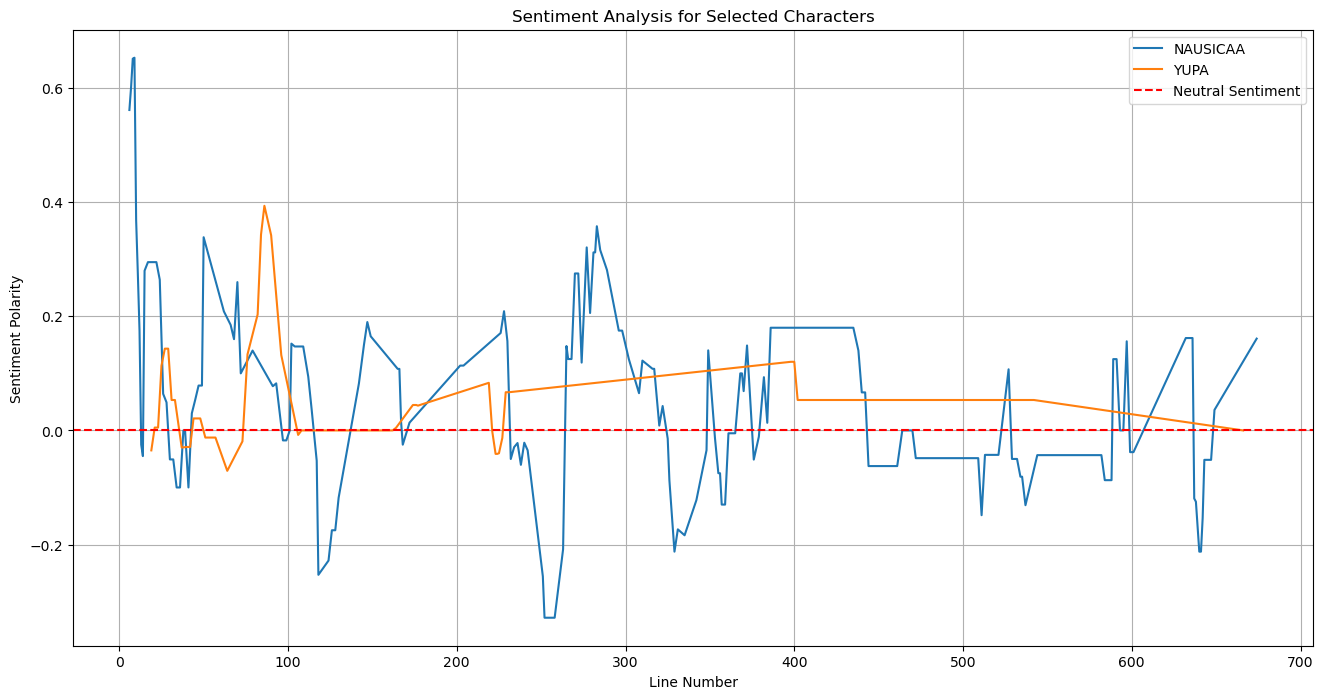

In [64]:

def analyze_characters_sentiment(script_dict, characters_to_plot):
    plt.figure(figsize=(16, 8))
    
    for character in characters_to_plot:
        
        line_numbers = []
        sentiments = []
        for line in script_dict[character]:

            line_number, text = line.split(">", 1)
            line_number = int(line_number.strip("<"))
            line_numbers.append(line_number)
            
            sentiment = TextBlob(text).sentiment.polarity
            sentiments.append(sentiment)
        
        window_size = 5
        smoothed_sentiments = np.convolve(sentiments, np.ones(window_size)/window_size, mode='valid')
        smoothed_line_numbers = line_numbers[window_size - 1:len(smoothed_sentiments) + window_size - 1]

        plt.plot(smoothed_line_numbers, smoothed_sentiments, label=character)

    plt.axhline(0, color="red", linestyle="--", label="Neutral Sentiment")
    plt.title("Sentiment Analysis for Selected Characters")
    plt.xlabel("Line Number")
    plt.ylabel("Sentiment Polarity")
    plt.legend()
    plt.grid(True)
    plt.show()



analyze_characters_sentiment(script_dict, ["NAUSICAA", "YUPA"])
# analyze_characters_sentiment(script_dict, script_dict.keys())

## Select Character Sentiment Analysis (with smoothing)

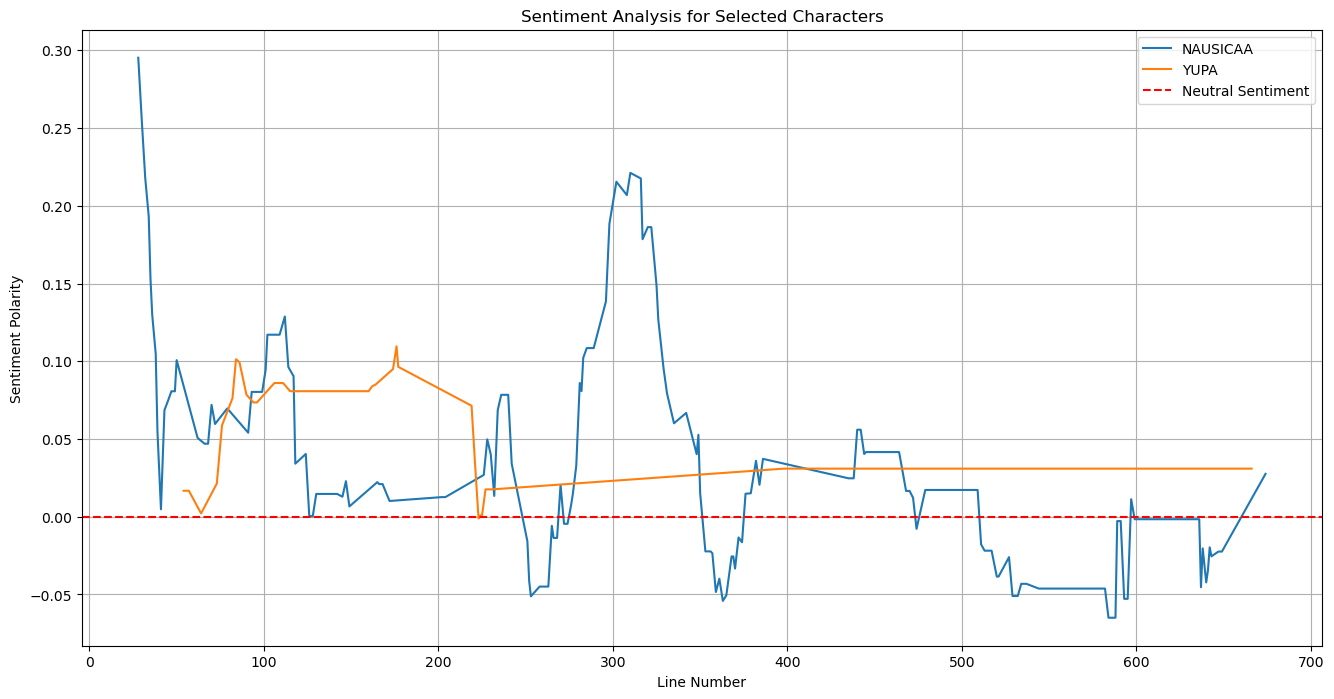

In [65]:
def analyze_characters_sentiment(script_dict, characters_to_plot, smoothing_window=5):
    plt.figure(figsize=(16, 8))
    
    for character in characters_to_plot:
        if character not in script_dict or not script_dict[character]:  
            print(f"No lines found for {character}. Skipping...")
            continue
        
        line_numbers = []
        sentiments = []
        for line in script_dict[character]:

            line_number, text = line.split(">", 1)
            line_number = int(line_number.strip("<"))
            line_numbers.append(line_number)
            
            sentiment = TextBlob(text).sentiment.polarity
            sentiments.append(sentiment)
        
        if len(sentiments) < smoothing_window:
            print(f"Not enough data points for {character} to apply smoothing with window size {smoothing_window}. Skipping...")
            continue
        
        smoothed_sentiments = np.convolve(sentiments, np.ones(smoothing_window)/smoothing_window, mode='valid')
        smoothed_line_numbers = line_numbers[smoothing_window - 1:len(smoothed_sentiments) + smoothing_window - 1]

        plt.plot(smoothed_line_numbers, smoothed_sentiments, label=character)

    plt.axhline(0, color="red", linestyle="--", label="Neutral Sentiment")
    plt.title("Sentiment Analysis for Selected Characters")
    plt.xlabel("Line Number")
    plt.ylabel("Sentiment Polarity")
    plt.legend()
    plt.grid(True)
    plt.show()


analyze_characters_sentiment(script_dict, ["NAUSICAA", "YUPA"], smoothing_window=20)
# analyze_characters_sentiment(script_dict, script_dict.keys(), smoothing_window=10)

## Participation Vector Smoothing

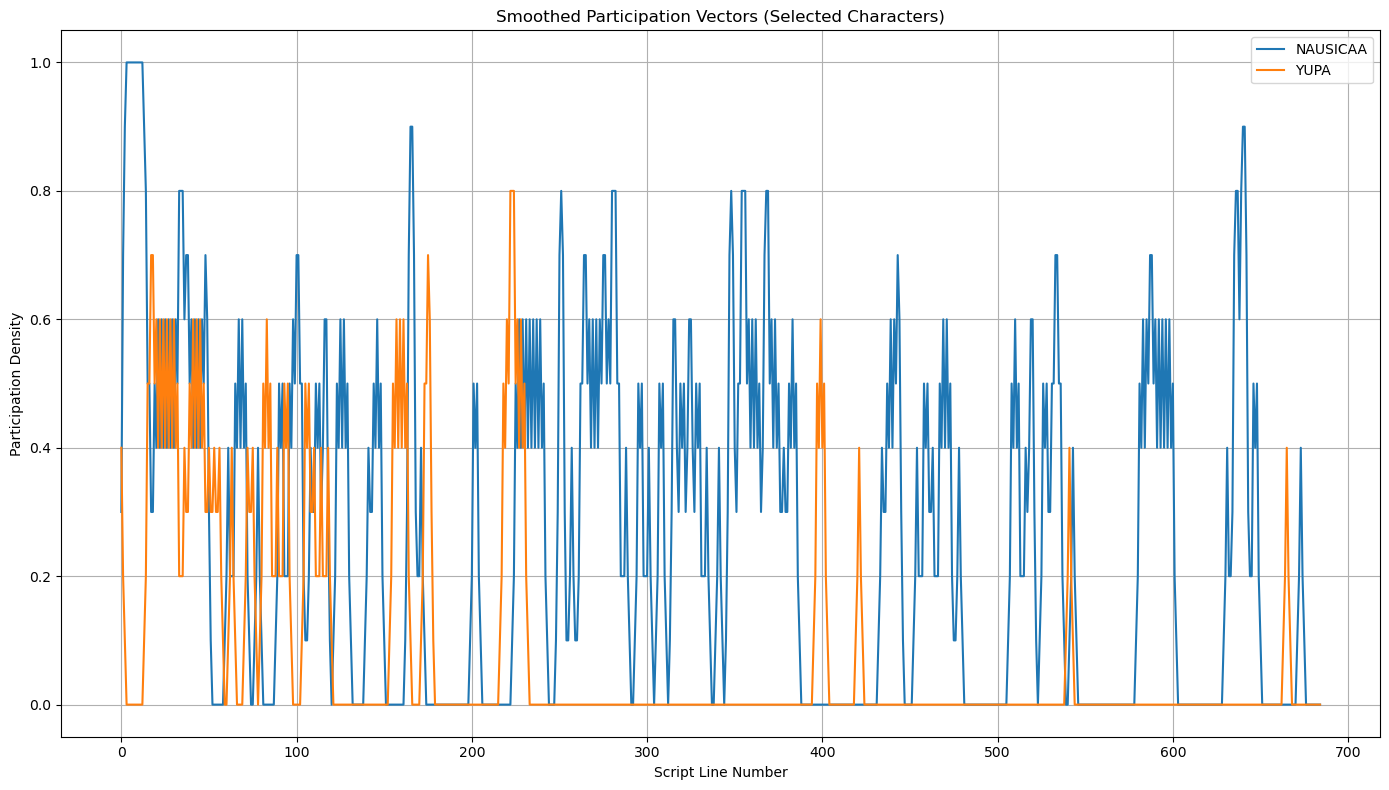

In [66]:
def plot_selected_participation(script_dict, total_lines, kernel, characters_to_plot):
    plt.figure(figsize=(14, 8))
    
    for character in characters_to_plot:
        if character not in script_dict:
            print(f"Warning: Character '{character}' not found in script_dict.")
            continue
        
        P = np.zeros(total_lines)
        for line in script_dict[character]:
            if line.startswith("<") and ">" in line:
                line_num = int(line[1:line.index(">")])
                if 0 < line_num <= total_lines:
                    P[line_num - 1] = 1
        
        P_smooth = np.convolve(P, kernel, mode='same')
        plt.plot(P_smooth, label=character)

    plt.title("Smoothed Participation Vectors (Selected Characters)")
    plt.xlabel("Script Line Number")
    plt.ylabel("Participation Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

kernel = np.array([0.1, 0.2, 0.4, 0.2, 0.1])
plot_selected_participation(script_dict, 685, kernel, ["NAUSICAA", "YUPA"])
# plot_selected_participation(script_dict, 685, kernel, script_dict.keys())

## PCA Plot Showing Sentiment Dynamics Over Script
- PC1 (blue) captures the dominant sentiment trend shaped by all characters.
- PC2 (green) likely reflects contrastive patterns — for example, moments when emotionally divergent characters (like Nausicaa vs. Kushana) interact.

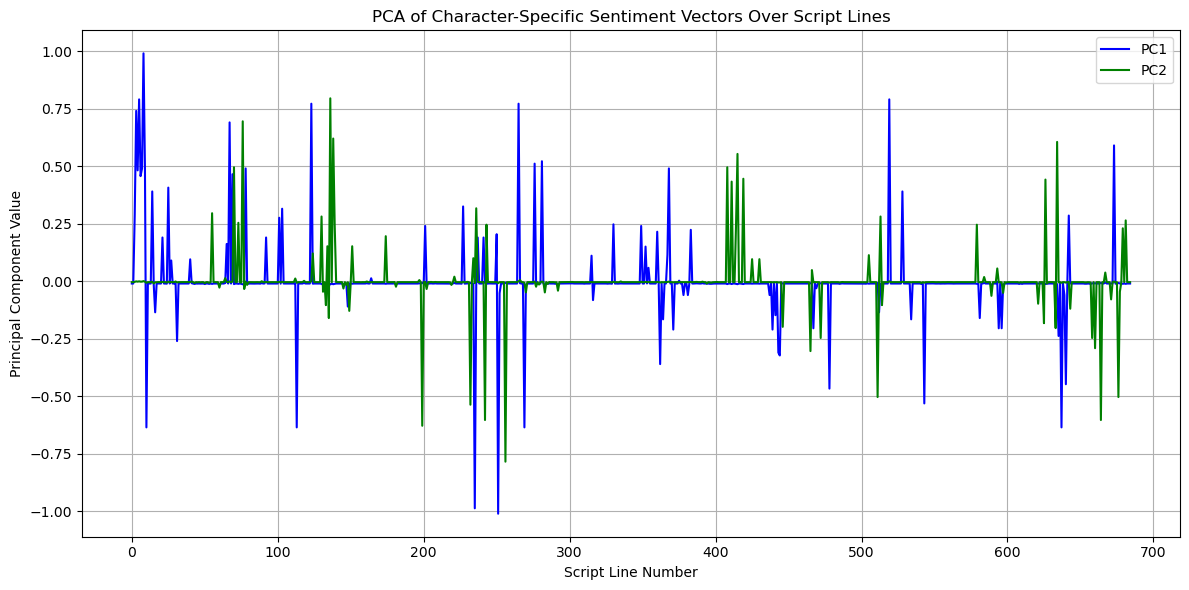

In [67]:
total_lines = len(all_lines_ordered)

sentiment_vector = np.zeros(total_lines)
for idx, (_, _, text) in enumerate(all_lines_ordered):
    sentiment_vector[idx] = TextBlob(text).sentiment.polarity

# Participation matrix
characters = list(script_dict.keys())
P_matrix = np.zeros((len(characters), total_lines))

for i, char in enumerate(characters):
    for line in script_dict[char]:
        if line.startswith("<") and ">" in line:
            line_num = int(line[1:line.index(">")])
            if 0 < line_num <= total_lines:
                P_matrix[i, line_num - 1] = 1

character_sentiments = P_matrix * sentiment_vector

X = character_sentiments.T
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(12, 6))
plt.plot(X_pca[:, 0], label="PC1", color="blue")
plt.plot(X_pca[:, 1], label="PC2", color="green")
plt.title("PCA of Character-Specific Sentiment Vectors Over Script Lines")
plt.xlabel("Script Line Number")
plt.ylabel("Principal Component Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Comparing to Joseph Campbell's Idea of A Heros Journey

<img src="Images/monomyth.jpg">
<div style="background-color: white; display: inline-block; padding: 10px;">
  <img src="Images/Heroesjourney.svg" width="500">
</div>


/tmp/ipykernel_58451/3802747897.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(heros_journey_phases))


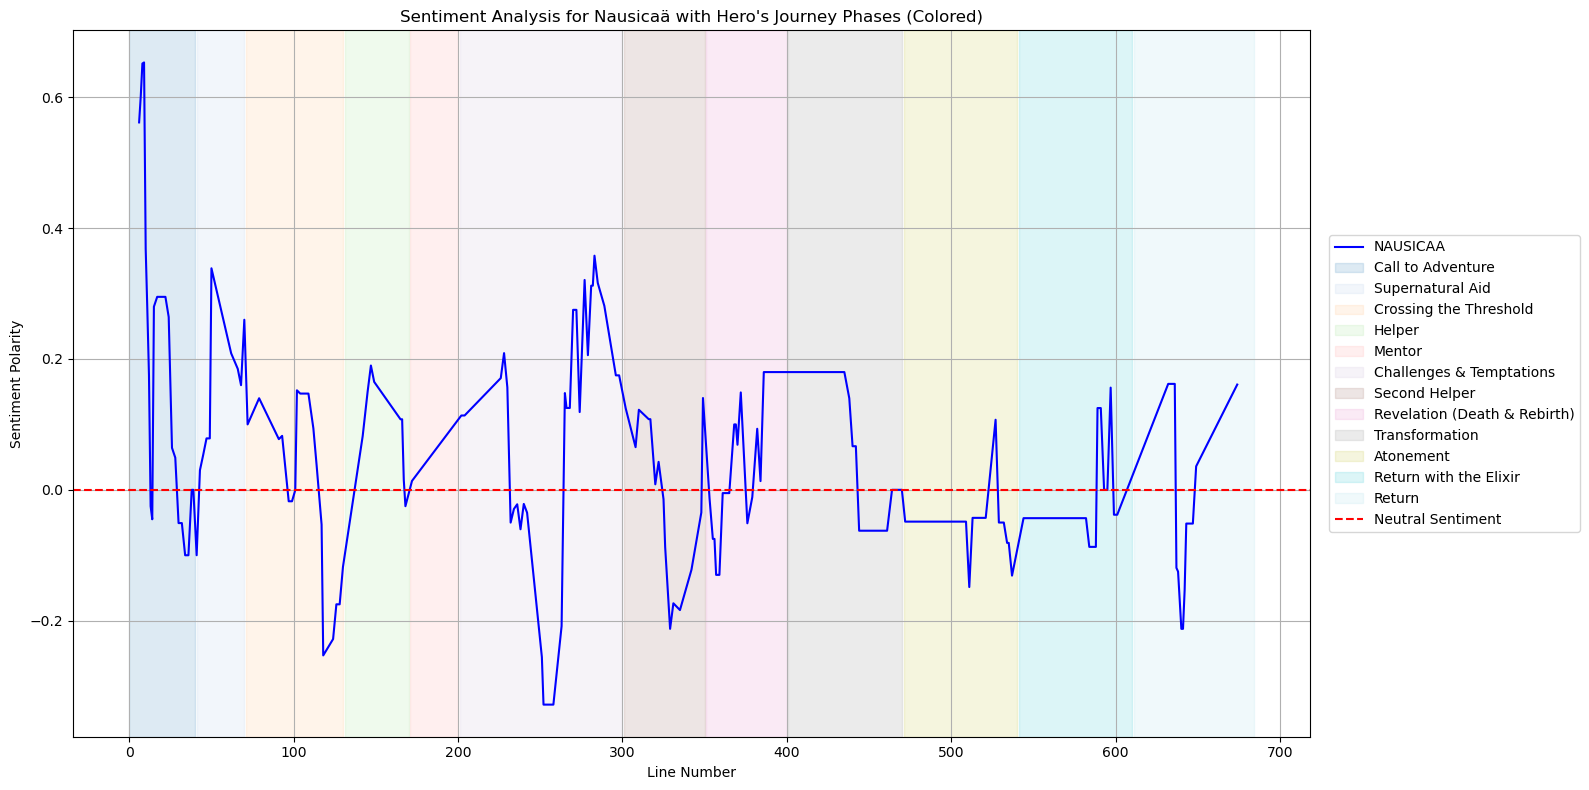

In [68]:

# Hero's Journey phases (bounds)
heros_journey_phases = {
    "Call to Adventure": (0, 40),
    "Supernatural Aid": (41, 70),
    "Crossing the Threshold": (71, 130),
    "Helper": (131, 170),
    "Mentor": (171, 200),
    "Challenges & Temptations": (201, 300),
    "Second Helper": (301, 350),
    "Revelation (Death & Rebirth)": (351, 400),
    "Transformation": (401, 470),
    "Atonement": (471, 540),
    "Return with the Elixir": (541, 610),
    "Return": (611, 684)
}

cmap = cm.get_cmap('tab20', len(heros_journey_phases))
phase_colors = {phase: cmap(i) for i, phase in enumerate(heros_journey_phases)}

def analyze_characters_sentiment_colored(script_dict, characters_to_plot, phases, colors):
    plt.figure(figsize=(16, 8))

    for character in characters_to_plot:
        line_numbers = []
        sentiments = []
        for line in script_dict[character]:
            line_number, text = line.split(">", 1)
            line_number = int(line_number.strip("<"))
            line_numbers.append(line_number)

            sentiment = TextBlob(text).sentiment.polarity
            sentiments.append(sentiment)
            

        window_size = 5
        smoothed_sentiments = np.convolve(sentiments, np.ones(window_size)/window_size, mode='valid')
        smoothed_line_numbers = line_numbers[window_size - 1:len(smoothed_sentiments) + window_size - 1]

        plt.plot(smoothed_line_numbers, smoothed_sentiments, label=character, color='blue')

    for phase, (start, end) in phases.items():
        plt.axvspan(start, end, alpha=0.15, color=colors[phase], label=phase)

    plt.axhline(0, color="red", linestyle="--", label="Neutral Sentiment")
    plt.title("Sentiment Analysis for Nausicaä with Hero's Journey Phases (Colored)")
    plt.xlabel("Line Number")
    plt.ylabel("Sentiment Polarity")
    plt.legend(loc="center left", bbox_to_anchor=(1.01, 0.5))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

analyze_characters_sentiment_colored(script_dict, ["NAUSICAA"], heros_journey_phases, phase_colors)


## Smoother Graph

/tmp/ipykernel_58451/3956316191.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(heros_journey_phases))


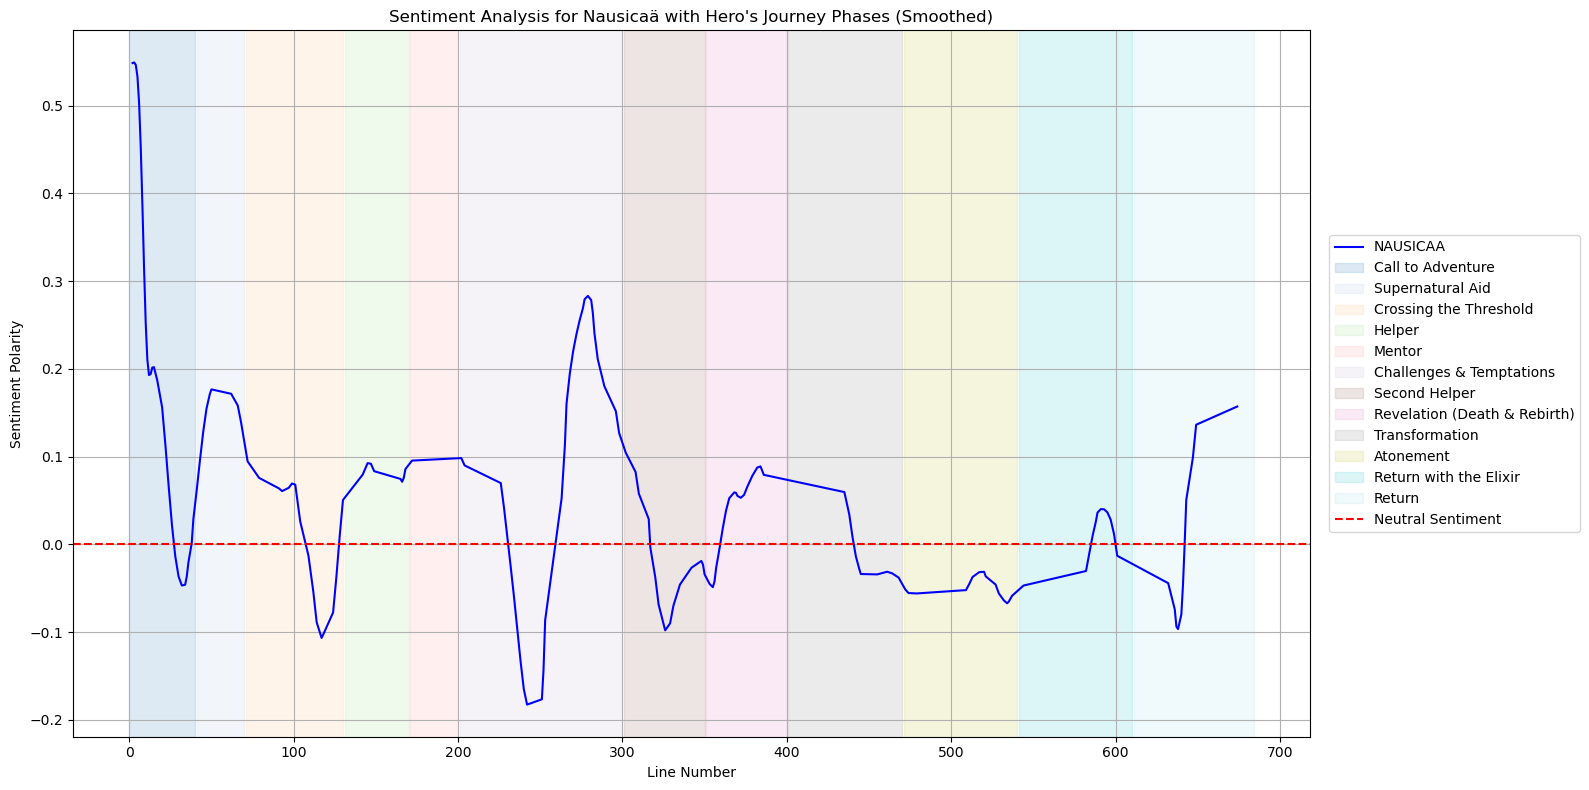

In [69]:


cmap = cm.get_cmap('tab20', len(heros_journey_phases))
phase_colors = {phase: cmap(i) for i, phase in enumerate(heros_journey_phases)}

def analyze_characters_sentiment_colored(script_dict, characters_to_plot, phases, colors):
    plt.figure(figsize=(16, 8))

    for character in characters_to_plot:
        line_numbers = []
        sentiments = []
        for line in script_dict[character]:
            line_number, text = line.split(">", 1)
            line_number = int(line_number.strip("<"))
            line_numbers.append(line_number)
            sentiment = TextBlob(text).sentiment.polarity
            sentiments.append(sentiment)

        smoothed_sentiments = gaussian_filter1d(sentiments, sigma=3)

        plt.plot(line_numbers, smoothed_sentiments, label=character, color='blue')

    for phase, (start, end) in phases.items():
        plt.axvspan(start, end, alpha=0.15, color=colors[phase], label=phase)

    plt.axhline(0, color="red", linestyle="--", label="Neutral Sentiment")
    plt.title("Sentiment Analysis for Nausicaä with Hero's Journey Phases (Smoothed)")
    plt.xlabel("Line Number")
    plt.ylabel("Sentiment Polarity")
    plt.legend(loc="center left", bbox_to_anchor=(1.01, 0.5))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

analyze_characters_sentiment_colored(script_dict, ["NAUSICAA"], heros_journey_phases, phase_colors)


## Export Data

In [ ]:
character = "NAUSICAA"
line_numbers = []
sentiments = []
for line in script_dict[character]:
    line_number, text = line.split(">", 1)
    line_number = int(line_number.strip("<"))
    line_numbers.append(line_number)
    sentiment = TextBlob(text).sentiment.polarity
    sentiments.append(sentiment)

smoothed_sentiments = gaussian_filter1d(sentiments, sigma=3)

sentiment_data = [
    {"line": int(ln), "sentiment": float(s)}
    for ln, s in zip(line_numbers, smoothed_sentiments)
]

with open('heros-journey-site/src/data/sentiment_data.json', 'w') as f:
    json.dump(sentiment_data, f, indent=4)

phases_data = [
    {"name": phase, "start": bounds[0], "end": bounds[1]}
    for phase, bounds in heros_journey_phases.items()
]

with open('heros-journey-site/src/data/phases.json', 'w') as f:
    json.dump(phases_data, f, indent=4)

Exported sentiment_data.json and phases.json!
